In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops
from scipy.ndimage import binary_dilation

In [2]:
from pyometiff import OMETIFFWriter

def save_ome_tif(filename, img):
    """
    Save the ome.tif file.
    """
    writer = OMETIFFWriter(fpath = filename, array = img, metadata = {})
    writer.write()

In [3]:
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (5, 5), dpi = 80)
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

### Load in the image

In [31]:
sender_image = plt.imread("./Txn_series6_30min_sender.tif")
receiver_image = plt.imread("./Txn_series6_30min_receiver.tif")


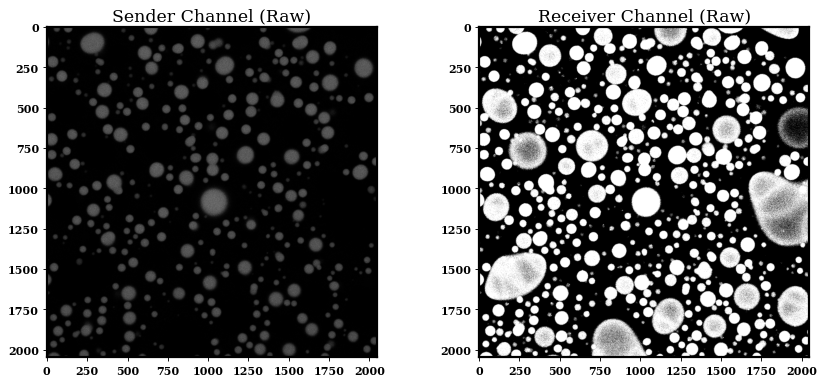

In [43]:
fig = plt.figure(figsize=(11, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Sender Channel (Raw)")
plt.imshow(sender_image, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Receiver Channel (Raw)")
binary = receiver_image > (receiver_image.mean() + receiver_image.std()*0.05)
plt.imshow(binary, cmap="gray")

plt.tight_layout()
plt.show()

### Sender receiver droplet identification

In [44]:
def droplet_detection(sender_image, receiver_image):
    """
    Identify the locations of the sender and receiver droplets.
    """
    # Create Binary for better signal to noise
    binary = sender_image > (sender_image.mean() + sender_image.std())

    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    senders = [i for i in blob_lists if i.area > 500]
    
    # Mask to document all sender locations
    mask = np.zeros_like(binary)
    for i in senders:
        minr, minc, maxr, maxc = i.bbox
        mask[minr:maxr, minc:maxc] = 1
        
    # Create Binary for better signal to noise
    binary = receiver_image > (receiver_image.mean() + receiver_image.std()*0.05)
    
    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    receivers = [i for i in blob_lists if i.area > 500]

    # Extract receiver droplets
    true_receivers = []
    for i in receivers:
        minr, minc, maxr, maxc = i.bbox
        if mask[int((minr+maxr)/2), int((minc+maxc)/2)] == 0:
            true_receivers.append(i)
            
    return senders, true_receivers

In [45]:
senders, receivers = droplet_detection(sender_image, receiver_image)

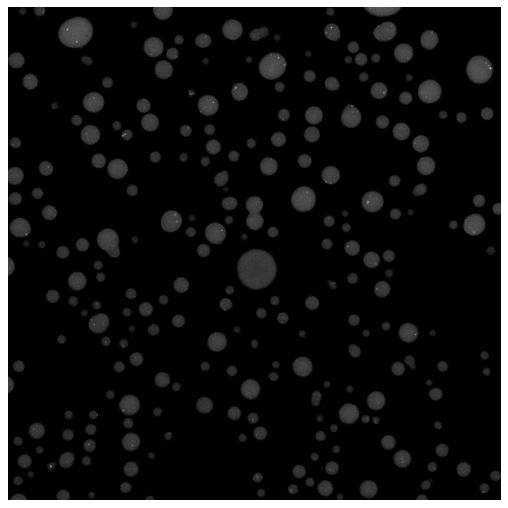

In [46]:
blank = np.zeros_like(sender_image)

for droplet in senders:

    minr, minc, maxr, maxc = droplet.bbox
    
    cropped = receiver_image[minr:maxr, minc:maxc]
    
    mask = droplet.image
    
    for r in range(minr, maxr):
        for c in range(minc, maxc):
            r_r = r - minr
            r_c = c - minc
            if mask[r_r, r_c]:
                blank[r, c] = cropped[r_r, r_c]
    
figure = plt.figure(figsize=(8, 8), dpi = 80)

plt.imshow(blank, cmap = 'gray')

plt.axis(False)

save_ome_tif("Txn_series6_30min_sender_cropped.tif", blank.reshape(1, 2048, 2048))

plt.show()

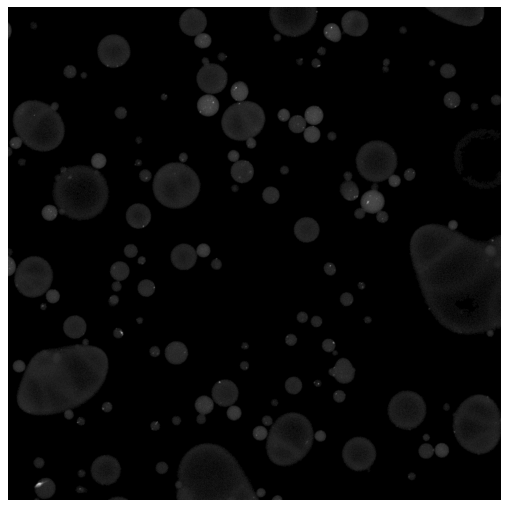

In [47]:
blank = np.zeros_like(sender_image)

for droplet in receivers:

    minr, minc, maxr, maxc = droplet.bbox
    
    cropped = receiver_image[minr:maxr, minc:maxc]
    
    mask = droplet.image
    
    for r in range(minr, maxr):
        for c in range(minc, maxc):
            r_r = r - minr
            r_c = c - minc
            if mask[r_r, r_c]:
                blank[r, c] = cropped[r_r, r_c]
    
figure = plt.figure(figsize=(8, 8), dpi = 80)

plt.imshow(blank, cmap = 'gray')

plt.axis(False)

save_ome_tif("Txn_series6_30min_receiver_cropped.tif", blank.reshape(1, 2048, 2048))

plt.show()